In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [24]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [25]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [26]:
# 数据归一化处理
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
mm = MinMaxScaler([-1, 1])
x_data_mm = mm.fit_transform(x_data)
# 数据降维
# pca = PCA(n_components=10) 
# x_data_mm_pca = pca.fit_transform(x_data_mm)
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data_mm,y_data)

In [27]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [28]:
# 重置数据维度
x_train = x_train.reshape(-1,1,x_train.shape[-1])
x_test = x_test.reshape(-1,1,x_test.shape[-1])
print(x_train.shape)

(1777, 1, 2000)


In [29]:
# 对类别数据进行onehot编码
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [30]:
# 构建网络
model = Sequential() 

model.add(Conv1D(128,16, activation='relu', padding='same'))
model.add(Conv1D(128,8, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, padding='same'))


model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu', input_dim=x_train.shape[-1], input_length=x_train.shape[1])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

model.build(input_shape=x_train.shape)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            multiple                  4096128   
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  131200    
_________________________________________________________________
batch_normalization_3 (Batch multiple                  512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 multiple                  0         
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  98816     
_________________________________________________________________
batch_normalization_4 (Batch multiple                  512       
_________________________________________________________________
bidirectional_3 (Bidirection multiple                 

In [31]:
# 训练网络
epochs = 200 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V8_11.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/200
28/28 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.7034
Epoch 00001: val_accuracy improved from -inf to 0.46292, saving model to BiLSTM_V8_11.h5
28/28 [==============================] - 7s 256ms/step - loss: 0.6301 - accuracy: 0.7034 - val_loss: 0.6939 - val_accuracy: 0.4629 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.7738
Epoch 00002: val_accuracy did not improve from 0.46292
28/28 [==============================] - 5s 173ms/step - loss: 0.4662 - accuracy: 0.7738 - val_loss: 0.6925 - val_accuracy: 0.4629 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.8633
Epoch 00003: val_accuracy improved from 0.46292 to 0.52360, saving model to BiLSTM_V8_11.h5
28/28 [==============================] - 5s 185ms/step - loss: 0.3235 - accuracy: 0.8633 - val_loss: 0.6832 - val_accuracy: 0.5236 - lr: 0.0010
Epoch 4/200
28/28 [============================

Epoch 28/200
28/28 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9910
Epoch 00028: val_accuracy did not improve from 0.70112
28/28 [==============================] - 6s 213ms/step - loss: 0.0221 - accuracy: 0.9910 - val_loss: 2.0403 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 29/200
28/28 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9927
Epoch 00029: val_accuracy did not improve from 0.70112
28/28 [==============================] - 6s 214ms/step - loss: 0.0174 - accuracy: 0.9927 - val_loss: 2.3487 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 30/200
28/28 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9932
Epoch 00030: val_accuracy did not improve from 0.70112

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 [==============================] - 6s 206ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.8216 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 31/200
28/28 [==============

Epoch 55/200
28/28 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994
Epoch 00055: val_accuracy did not improve from 0.91011
28/28 [==============================] - 6s 216ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.8126 - val_accuracy: 0.8787 - lr: 5.0000e-04
Epoch 56/200
28/28 [==============================] - ETA: 0s - loss: 6.9057e-04 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.91011
28/28 [==============================] - 6s 214ms/step - loss: 6.9057e-04 - accuracy: 1.0000 - val_loss: 0.7035 - val_accuracy: 0.8989 - lr: 5.0000e-04
Epoch 57/200
28/28 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994
Epoch 00057: val_accuracy did not improve from 0.91011
28/28 [==============================] - 6s 212ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.7543 - val_accuracy: 0.8831 - lr: 5.0000e-04
Epoch 58/200
28/28 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983

Epoch 82/200
28/28 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9977
Epoch 00082: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 223ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.7971 - val_accuracy: 0.8584 - lr: 2.5000e-04
Epoch 83/200
28/28 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9989
Epoch 00083: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 214ms/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 1.6399 - val_accuracy: 0.7843 - lr: 2.5000e-04
Epoch 84/200
28/28 [==============================] - ETA: 0s - loss: 7.2890e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 216ms/step - loss: 7.2890e-04 - accuracy: 1.0000 - val_loss: 1.1109 - val_accuracy: 0.8180 - lr: 2.5000e-04
Epoch 85/200
28/28 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

Epoch 109/200
28/28 [==============================] - ETA: 0s - loss: 5.7348e-04 - accuracy: 1.0000
Epoch 00109: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 217ms/step - loss: 5.7348e-04 - accuracy: 1.0000 - val_loss: 0.6249 - val_accuracy: 0.9124 - lr: 1.2500e-04
Epoch 110/200
28/28 [==============================] - ETA: 0s - loss: 2.3891e-04 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 214ms/step - loss: 2.3891e-04 - accuracy: 1.0000 - val_loss: 0.5849 - val_accuracy: 0.9146 - lr: 1.2500e-04
Epoch 111/200
28/28 [==============================] - ETA: 0s - loss: 3.2618e-04 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 216ms/step - loss: 3.2618e-04 - accuracy: 1.0000 - val_loss: 0.5444 - val_accuracy: 0.9213 - lr: 1.2500e-04
Epoch 112/200
28/28 [==============================] - ETA: 0s - loss: 1.428

Epoch 136/200
28/28 [==============================] - ETA: 0s - loss: 1.5434e-04 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.93708

Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
28/28 [==============================] - 6s 210ms/step - loss: 1.5434e-04 - accuracy: 1.0000 - val_loss: 0.5316 - val_accuracy: 0.9236 - lr: 6.2500e-05
Epoch 137/200
28/28 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994
Epoch 00137: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 212ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.8910 - val_accuracy: 0.8764 - lr: 3.1250e-05
Epoch 138/200
28/28 [==============================] - ETA: 0s - loss: 1.8929e-04 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.93708
28/28 [==============================] - 6s 213ms/step - loss: 1.8929e-04 - accuracy: 1.0000 - val_loss: 0.9926 - val_accuracy: 0.8607 - lr: 3.1250e-05
Epo

28/28 [==============================] - ETA: 0s - loss: 5.2204e-04 - accuracy: 1.0000
Epoch 00162: val_accuracy did not improve from 0.93708
28/28 [==============================] - 4s 158ms/step - loss: 5.2204e-04 - accuracy: 1.0000 - val_loss: 0.5916 - val_accuracy: 0.9146 - lr: 1.5625e-05
Epoch 163/200
28/28 [==============================] - ETA: 0s - loss: 3.1911e-04 - accuracy: 1.0000
Epoch 00163: val_accuracy did not improve from 0.93708
28/28 [==============================] - 4s 158ms/step - loss: 3.1911e-04 - accuracy: 1.0000 - val_loss: 0.5898 - val_accuracy: 0.9124 - lr: 1.5625e-05
Epoch 164/200
28/28 [==============================] - ETA: 0s - loss: 1.4857e-04 - accuracy: 1.0000
Epoch 00164: val_accuracy did not improve from 0.93708
28/28 [==============================] - 4s 157ms/step - loss: 1.4857e-04 - accuracy: 1.0000 - val_loss: 0.5799 - val_accuracy: 0.9146 - lr: 1.5625e-05
Epoch 165/200
28/28 [==============================] - ETA: 0s - loss: 2.5170e-04 - accura

Epoch 189/200
28/28 [==============================] - ETA: 0s - loss: 3.5027e-04 - accuracy: 1.0000
Epoch 00189: val_accuracy did not improve from 0.93708
28/28 [==============================] - 5s 161ms/step - loss: 3.5027e-04 - accuracy: 1.0000 - val_loss: 0.5551 - val_accuracy: 0.9169 - lr: 7.8125e-06
Epoch 190/200
28/28 [==============================] - ETA: 0s - loss: 2.0910e-04 - accuracy: 1.0000
Epoch 00190: val_accuracy did not improve from 0.93708
28/28 [==============================] - 4s 156ms/step - loss: 2.0910e-04 - accuracy: 1.0000 - val_loss: 0.5526 - val_accuracy: 0.9169 - lr: 7.8125e-06
Epoch 191/200
28/28 [==============================] - ETA: 0s - loss: 3.0825e-04 - accuracy: 1.0000
Epoch 00191: val_accuracy did not improve from 0.93708
28/28 [==============================] - 4s 159ms/step - loss: 3.0825e-04 - accuracy: 1.0000 - val_loss: 0.5561 - val_accuracy: 0.9169 - lr: 7.8125e-06
Epoch 192/200
28/28 [==============================] - ETA: 0s - loss: 1.222

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


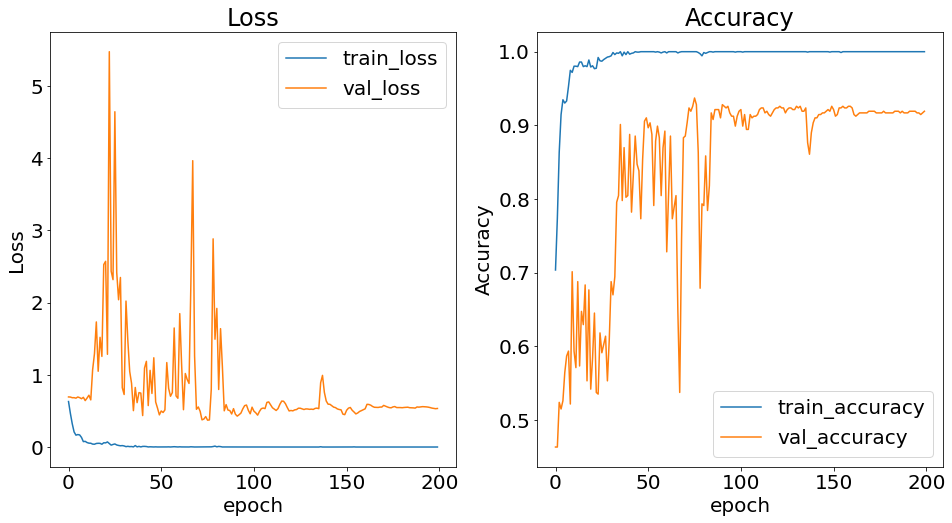

In [32]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [33]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V8_11.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [34]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 0.9994% 召回率: 0.9988532110091743, f1: 0.9994262765347103
在20%测试集上, accuracy: 0.9371% 召回率: 0.9707112970711297, f1: 0.943089430894309


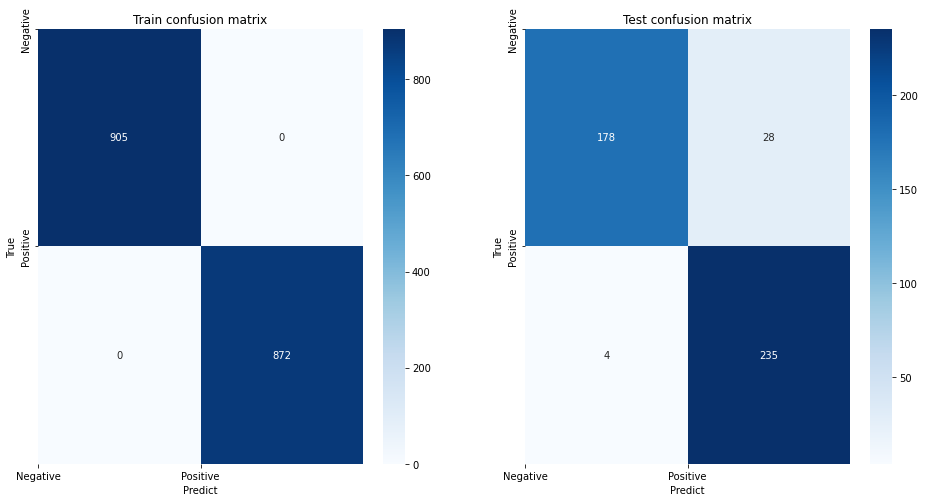

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()